 
<table style="width:100%">
  <tr style="background-color:#002147">
    <th>![logo.png](attachment:logo.png)</th>
    <th><p style="color:white">Software Engineering Programme</th> 
  </tr>
</table>



#  Things of the Internet (TOI)





# LAB 1: RF Based Positioning

##  Introduction

Localization is a key capability for things of the internet. Things need to know where they are to provide context to sensor readings. There are many ways of working out where a sensor is, ranging from GPS to inertial measurement units. However, one of the simplest techniques is to use measurements of ambient radio signal strength e.g. WiFi. Things are equipped with wireless transceivers anyway for communication, so the key is to try and exploit the transceiver to give measurements of location. This is particularly well suited to indoor settings, where a number of APs (access points/routers) are installed to provide good communication coverage so mobile devices can connect to a wireless network. The operating principle is simple: the closer the device is to an AP, the stronger the received signal strength is. However, the devil is in the details – the surrounding environment (walls, people, furniture, obstacles etc etc) all conspire to alter the relationship between signal strength and distance, so what starts off as a nice straight line in theory, turns into a very wiggly and noisy relationship. What is worse, this relationship is dynamic as well – a stationary WiFi device will typically experience a variation in signal strength over time.

So the question is: how are we going to use these noisy measurements to estimate a device’s location and how accurate can it be?
Rather than using a physics based model and trying to model and represent all the sources of disturbance, we take a much simpler approach. We approach the problem by breaking it down into two stages. In the first stage (the offline phase), we manually survey the signal strengths, i.e. we stand in a surveyed location and record what APs can be heard and with what strength. We obtain a vector (tuple) of measurements e.g. <X:-20,Y:-30,Z-32> could be the vector from one location, where we can hear APs X,Y and Z and <W:-40,Z-60> could be the vector from another location where we can hear APs W and Z. These vectors of signal strength are commonly called fingerprints i.e. the hope is that they are sufficiently unique and discriminative such that every location has a different fingerprint. Obviously, there is a time (and consequently financial) cost in building the map, so there is a question about how precisely the map needs to be surveyed e.g. on a 1 m grid spacing or on a 5 m grid spacing or even simply in the centre of each room.

In the second phase (the online phase), the device will record a vector of signal strengths. The goal now is to come up with some algorithm that, with the aid of the map collected in the offline phase, could accurately determine the location of the device. There are many different approaches to doing this, and the aim of this lab is to demonstrate how a location system could be built using WiFi signal strength measurements, to consider factors which would impact its performance, and to discuss its relative merits.


<div class="alert alert-warning">
<b>NOTE</b> For reasons of compatibility with the existing MAC workstation install, this notebook is running in Python 2.7. Please see https://ipython.readthedocs.io/en/stable/install/kernel_install.html for information on how to set up a 2.7 kernel on Python 3 (or indeed vice versa).
</div> 


In [ ]:
# This is just some magic to install modules if they haven't already been installed. We don't use pip directly, as it can lead 
# to wierdness with paths etc.

!python -m pip install numpy --user
!python -m pip install matplotlib --user
!python -m pip install scipy --user
!python -m pip install statsmodels --user
!python -m pip install pandas --user

# we also use this magic to reload modules, rather than caching them
%load_ext autoreload
%autoreload 2

## Exploratory Data Analysis

We have collected a set of data for use in this lab, to save you the pain of having to manually survey signal strengths in the teaching room. During the offline phase we survey the environment collecting RSS measurements. For this demonstration we have collected 60 samples per location. Navigate to “data/set1/wifiData/” and open “Wifi_14.txt” with a text editor to look at a sample file. The first few lines look like the following:

`
2 4
1 AP_1 -37.89
2 AP_2 -52.63
3 AP_3 -44.98
4 AP_1 -38.68
5 AP_2 -61.14
6 AP_3 -35.08
7 AP_1 -39.46
8 AP_2 -61.62
9 AP_3 -47.00
10 AP_1 -38.00
11 AP_2 -60.69
.....`

The first line in the file is the survey coordinate i.e. (x = 2 m, y = 4 m).  The remainder of the lines detail the signal strengths in dBm from each access point. Note that each access point normally has a long BSSID as a unique identifier (e.g. `d8:c7:c8:cc:43:24`), but we have made things simpler here for ease of understanding.

Each file corresponds to a different survey location and typically 60 measurements are taken from each AP. In this dataset (set1), there are 3 APs in range, and in total we have collected Wi-Fi samples from 121 locations. 

During the online phase we want to estimate the user’s unknown location using RSS readings collected at that location. Navigate to “data/set1/testWifiData/” and answer the following questions:

<div class="alert alert-info">
Q: What is the number of unknown locations that we are going to estimate?
</div> 	

<div class="alert alert-info">
Q: How many RSS measurements have we collected per location per access point? 
</div> 	

<div class="alert alert-info">
Q: What do you see in the first line of each file? Comment on that.
</div> 	

Finally, we have collected two datasets (i.e. set1 and set2); set1 contains RSS measurements with respect to 3 APs and set2 with respect to 5 APs.


### Loading and visualizing

We have written some helper functions which load the datasets (both test and train) and visualize their spatial distribution, which can be found in `helper.py`. 

In [ ]:
import helper as myhelper

The function `load_wifi_data` has the following API

```python
def load_wifi_data(data_folder, n_samples, n_ap):
    """
    :param data_folder: Location of WiFi RSS data
    :param n_samples: Number of RSS samples to return for each location
    :param n_ap: Number of access points
    :return: train and test wifi databases
    """
 ```
 
Lets load up the train and test datasets from Set1 (3 APs).

In [ ]:
import os
parent_dir = os.path.abspath(os.path.join('..'))
datasetpath = os.path.join(parent_dir,'lab1','data','set1')
NUMBER_OF_APS = 3
MAX_SAMPLES = 60
trainData,testData = myhelper.load_wifi_data(datasetpath,MAX_SAMPLES,NUMBER_OF_APS)

The dataset is stored simply as a large array, with the following structure.
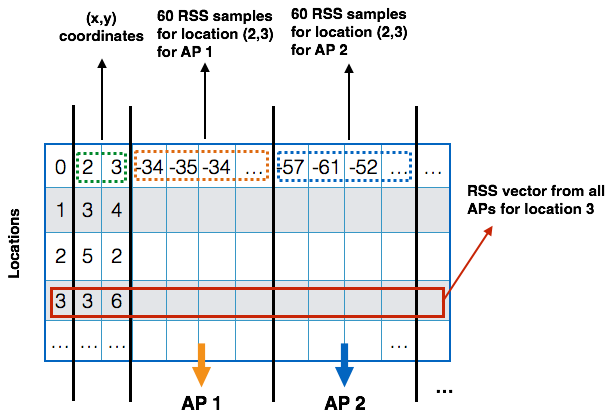


<div class="alert alert-info">
Q: Do you think this is the best representation of the dataset? What would be a better (and indeed more Pythonic) way?
</div> 

Lets look at the first row of the training dataset. It corresponds to the readings obtained from the location (0,0)



In [ ]:
# look a the first row of the array
trainData[0,:]

Investigate the sample strengths from AP1 at this location point, using the snippet below. 

<div class="alert alert-info">
Q: What do you notice about the signal strength readings?
</div> 


In [ ]:
import pylab
signalStrengthAP1 = trainData[0,3:MAX_SAMPLES+3] # We use 3 as an offset to handle the location/file-info in the array.
pylab.plot(signalStrengthAP1)
pylab.show()

Change the location index and examine what happens to the signal strength. Is there any pattern you can see?

<div class="alert alert-info">
Q: Can you estimate the likely position of AP1?
</div> 

<div class="alert alert-success">
Advanced question: Can you visualize 2-D map of signal strength for each access point?
</div> 

## A simple approach to finding location

Now that we have a better understanding of how the signals vary over space (and time), we can now try and solve the localization problem: given a set of signal strengths at an unknown location and an offline map, can we find the best estimate of the device position?

One of the simplest approaches is just a nearest neighbour lookup i.e. we just compare our candidate set of signal strengths to the signal strengths in the offline map and find the closest match. 

<div class="alert alert-info">
Q: What would be a good way of working out how "far" two sets of signal strengths are from each other?
</div> 

Rather than using all the raw information in the table, it perhaps would be more helpful to turn the 60 readings from each AP into representative statistics. 

<div class="alert alert-info">
Q: What are some sensible statistics that could be used?
</div>

In this approach, we will simply compute the mean of the readings in the map for each AP. We will then compute the difference between the trial signal strength and each of the values in the map, recording the index of the smallest distance. Lets start from the first point in the testData set.

<div class="alert alert-info">
Q: What is the ground-truth location of this point?
</div>

Fill in the skeleton code below to find the closest point in the offline map to the candidate point. Note that although we also take 60 samples in the test data set, we are just using the first sample point i.e. an instantaneous snap-shot.

In [ ]:
import numpy
# Take out the first row out of the testData set
testRow = testData[0,:]
# Extract the ground-truth location
groundTruthX = testRow[1]
groundTruthY = testRow[2]
# Take the Signal Strengths of each AP in the trial point
testAP1 = testRow[3]
testAP2 = testRow[3+MAX_SAMPLES]
testAP3 = testRow[3+MAX_SAMPLES*2]
# Iterate through the map
for k in range(numpy.shape(trainData)[0]):
    surveyAP1mean = numpy.mean(trainData[k,3:3+MAX_SAMPLES])
    surveyAP2mean = numpy.mean(trainData[k,3+MAX_SAMPLES:3+2*MAX_SAMPLES])
    surveyAP3mean = numpy.mean(trainData[k,3+2*MAX_SAMPLES:3+3*MAX_SAMPLES])
    # compute the score here, and record the best position in the map
    # ....
# report on the best position and compare to the ground-truth position to get a distance error
# ...    

<div class="alert alert-info">
Q: What is the distance error between the ground-truth location and the closest match in the map?
</div>

<div class="alert alert-info">
Q: Can you suggest some ways of potentially improving the accuracy? What is the relative tradeoff? Implement and see whether you get a smaller error
</div>

<div class="alert alert-info">
Q: Wrap your code into a function `predict()` that you can use to run through all the test points to compute errors for each test location. What is the mean overall error? What is the worst case error? Which do you think is more important for a location system and why?
</div>

<div class="alert alert-info">
Q: Instead of finding the best (closest) match in the map, what if you instead found the top-k matches and then computed their mean? Do this centroid-weighting approach help or not?
</div>

## HORUS: A probabilistic approach to location finding



Instead of just taking the mean value of the signal strengths in the map, we can consider including higher-order statistics as well, e.g. the variance (or standard-deviation) that reflect the variability in the signal over time. One of the first approaches to wifi fingerprinting proposed just this technique, which we will implement a simplified version of.

> Youssef, Moustafa, and Ashok Agrawala. "The Horus WLAN location determination system." Proceedings of the 3rd international conference on Mobile systems, applications, and services. ACM, 2005.


### Mathematical Model

Let $X$ be a 2-dimensional physical space. At each location $x \in X$, we can measure the signal strength from $k$ access points. We denote the $k$-dimensional signal strength space as $S$. We denote samples from the signal strength space $S$ as $s$. We also assume that the samples from different access points are independent. 
The problem becomes, given a signal strength vector $s=(s_1, s_2 ... s_k)$ , we want to find the location $x \in X$ that maximizes the probability $\mathrm{P} (x \vert s)$

1)	*Offline phase:* During the offline phase, the Horus system estimates the signal strength histogram for each access point at each location. These histograms represent the Horus system’s radio map. 


2)	*Online phase:* Given a signal strength vector $s=(s_1, s_2 ... s_k)$ , we want to find the location $x \in X$ that maximizes the probability  $P(x  \vert   s)$, i.e. we want to find

$$\newcommand{\argmaxI}{\mathop{\mathrm{argmax}}\nolimits} \argmaxI_x \mathrm{P} (x \vert s)$$
 

Using Bayes’ theorem, this can be shown to be equivalent to:

$$\newcommand{\argmaxI}{\mathop{\mathrm{argmax}}\nolimits} 
\argmaxI_x \mathrm{P} (x \vert s) =
\argmaxI_x \mathrm{P} (s \vert x) =
\argmaxI_x \prod_{i=1}^{k} \mathrm{P} (s_i \vert x) $$
 
Effectively, it says that we should find the location in the map that would maximize the likelihood (probability) of resulting in the sampled measurements.

### Offline Phase: Build a histogram map

In the offline phase, instead of storing N different raw measurements, or aggregating them using their mean, we will instead look at their distribution. Lets first investigate how best to represent the distribution compactly.


<div class="alert alert-info">
Q: Plot a histogram (hint: use `pylab.hist()`) of signal strengths from one AP for one location. What do you notice about the distribution? Does this hold for other points in the survey dataset?
</div>


Rather than storing the histogram as a set of bins, we can represent it as a normal (Gaussian) distribution. The normal distribution is parameterized by a mean $\mu$ and standard deviation $\sigma$. We can fit a normal distribution to a histogram of signal strengths to compactly represent the random variations, regardless of the number of samples in the histogram. We can use the helper function with the API below to transform the raw signal strength databases into normally distributed data.

```python
def fit_data(train_db, n_samples, n_ap):
    """
    :param train_db: RSS points collected at known locations
    :param n_samples: Number of RSS samples per location
    :param n_ap: Number of access points
    :return: Wifi fingerprint database; We approximate the RSS at each location with a Gaussian
    """
```    

Given a raw dataset of signal strengths as above, this transforms it into an array with the following structure:

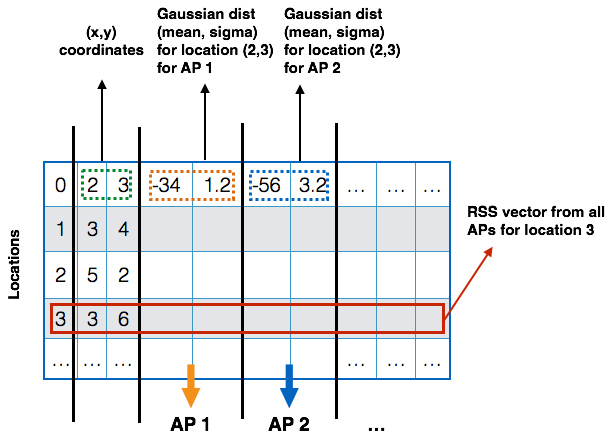

This is accomplished in the two lines of code below:

In [ ]:
normTrainData = myhelper.fit_data(trainData,MAX_SAMPLES,NUMBER_OF_APS)
normTestData = myhelper.fit_data(testData,MAX_SAMPLES,NUMBER_OF_APS)

<div class="alert alert-info">
Q: What are the pros and cons of using the Gaussian distribution to represent the signal strength histogram. Can you provide some specific scenarios where it would be a bad approximation?
</div>

### Online phase: find the best match

Make a new version of your `predict()` function above to use this probabilistic technique. In particular, you will need to compute the likelihood that a sample (e.g. the mean of signal strength from AP_1) is actually drawn from the offline-computed distribution. You can compute the likelihood as follows:

```python
from scipy.stats import norm

likelihood_AP1 = norm.pdf(trial_signal_strength_AP1, offline_mu_AP1, offline_sigma_AP1)
likelihood_AP2 = norm.pdf(trial_signal_strength_AP2, offline_mu_AP2, offline_sigma_AP2)
likelihood_AP3 = norm.pdf(trial_signal_strength_AP3, offline_mu_AP3, offline_sigma_AP3)
likelihood = likelihood_AP1 * likelihood_AP2 * likelihood_AP3
```

As the Bayes equation shows above, you can simply multiply these probabilities together. An alternative approach, which is numerically more stable, is to instead take the log-likelihood. By taking logs of both sides of the equation, the multiplication turns into an addition, and you can simply add the log-likelihood probabilities from each AP to obtain the overall log-likelihood.  

```python
from scipy.stats import norm

log_likelihood_AP1 = norm.logpdf(trial_signal_strength_AP1, offline_mu_AP1, offline_sigma_AP1)
log_likelihood_AP2 = norm.logpdf(trial_signal_strength_AP2, offline_mu_AP2, offline_sigma_AP2)
log_likelihood_AP3 = norm.logpdf(trial_signal_strength_AP3, offline_mu_AP3, offline_sigma_AP3)
log_likelihood = log_likelihood_AP1 + log_likelihood_AP2 + log_likelihood_AP3
```

<div class="alert alert-info">
Q: Implement the probabilistic approach to `predict()` and compare its performance to the methods based simply on the mean or the centroid.
</div>

<div class="alert alert-success">
Advanced question: Can you plot the error cumulative density function for each of your predict methods?
</div> 

<div class="alert alert-info">
Q: How well do your methods work for the other dataset, with 5 APs?
</div>

<div class="alert alert-info">
Q: Compare and contrast the techniques you have developed today. Consider aspects such as computational cost and factors such as how best to acquire and store the map. How can you update the map? Can you build a map without any surveying at all? Where should the computation happen? What is the impact of device specific variation e.g. different wireless network cards?
</div>